In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from consav import linear_interp

import LimitedCommitmentModel as brg

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
do_egm = True
threads = 16

In [2]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)
    model.cpp.delink()

# Solve and simulate from alternative models

In [3]:
# create a symmetric matrix with the highest values on the diagonal and values decreasing when moving through teh rows and colums
def create_asymmetric_matrix(n):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            A[i,j] = n - max(i,j)
    
    norm = A.sum(axis=0).reshape(-1,1)
    return A/norm

In [4]:
# create lower triangular matrix
def create_lower_triangular_matrix(n):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i>=j:
                A[i,j] = 1
    norm = A.sum(axis=1).reshape(-1,1)
    return A/norm


In [5]:
# settings for models to solve
T = 10
sigma = 0.1
num_love = 41
num_A = 50
num_A_pd = 50
num_power = 41

uniform_mat = np.ones((num_A,num_A))/num_A
asym_mat = create_asymmetric_matrix(num_A)
lo_tri = create_lower_triangular_matrix(num_A)

settings = {'centered_gradient':True, 
       'p_meet': 0.1, 
       'div_A_share': 0.5, 
       'sigma_love':sigma,
       'T':T,'do_cpp':do_cpp,
       'threads':threads, 
       'interp_power':False,
       'num_love': num_love,
       'num_A': num_A_pd, 
       'num_A_pd':num_A_pd,
       'num_power':num_power,}


specs = {
    'model 1':{'latexname':'Even share', 'par':{**settings, 'do_egm':True}},
    'model 2':{'latexname':'low divorce share', 'par':{**settings, 'do_egm':True, 'div_A_share':0.1}},
    # 'model 3':{'latexname':'Stochastic, EGM', 'par':{**settings, 'do_egm':True, 'prob_partner_A_w':lo_tri, 'prob_partner_A_m': lo_tri,}},
    # 'model 4':{'latexname':'Stochastic, VFI', 'par':{**settings, 'do_egm':False, 'prob_partner_A_w':lo_tri, 'prob_partner_A_m': lo_tri,}},
}




In [7]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()

m1 = models['model 1']
m2 = models['model 2']


solving model 1...
solving model 2...


In [8]:
m1.sol.barg_power

array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

In [16]:
## Re-compile and solve
for model in models.values():
    model.cpp.delink()

recompile = True
for name in models.keys():
    models[name].link_to_cpp(force_compile=recompile)

    print(f'solving {name}...')
    # models[name].allocate()
    # models[name].solve()

    recompile = False

m1 = models['model 1']
m2 = models['model 2']

solving model 1...
solving model 2...


In [24]:
t = 9
iL = 18
love = m1.par.grid_love[iL]
iAw = 1
iAm = 1
Aw = m1.par.grid_Aw[iAw]
Am = m1.par.grid_Am[iAm]
A_tot = Aw+Am
print(f'Aw: {Aw}, Am: {Am}, love: {love}')
m1.cpp.calc_init_mu(t, love, Aw, Am, m1.sol, m1.par)

Aw: 0.10371595613272663, Am: 0.10371595613272663, love: -0.09999999999999998


0.5000000000000009

In [110]:
linear_interp.interp_1d(m1.par.grid_Aw, m1.sol.Vw_single_to_single[t], Aw)

-0.3831238653632859

In [111]:
linear_interp.interp_3d(m1.par.grid_power, m1.par.grid_love, m1.par.grid_A, m1.sol.Vw_single_to_couple[t], 0.5, love, A_tot)

0.5516209730302297

# Solution

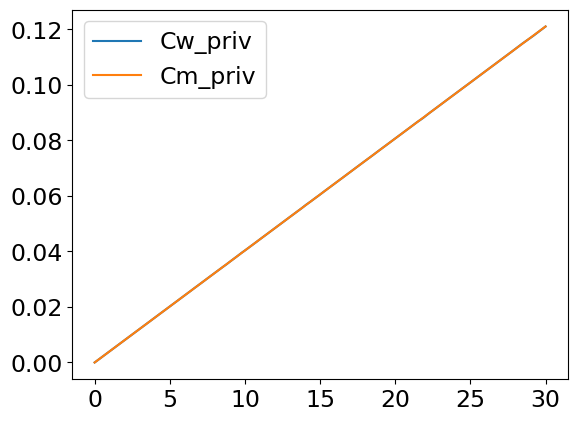

In [19]:
iP = 1
m = m1

plt.plot(m.par.grid_Ctot,(m.sol.pre_Ctot_Cw_priv[iP]), label='Cw_priv')
plt.plot(m.par.grid_Ctot,m.sol.pre_Ctot_Cm_priv[m.par.num_power-1-iP], label='Cm_priv')
# plt.plot(m.par.grid_Ctot, m.sol.pre_Ctot_C_pub[iP])
plt.legend()

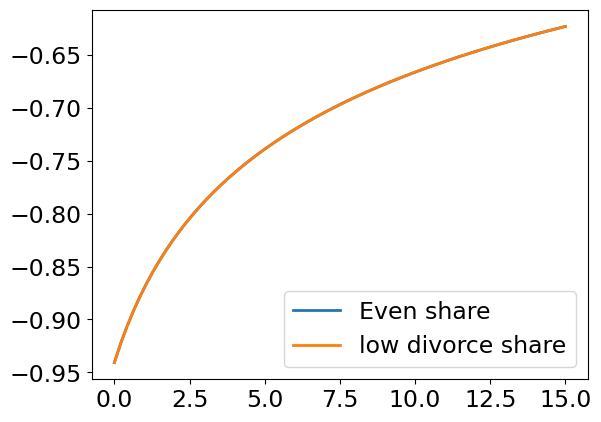

In [20]:
m=m1
t = 9
iL = 20
iP = 0
var = "Vw_single_to_couple"

for m in models.values():
    plt.plot(m.par.grid_A, getattr(m.sol,var)[t,iP,iL], label=m.spec['latexname'], linewidth=2)

plt.legend()

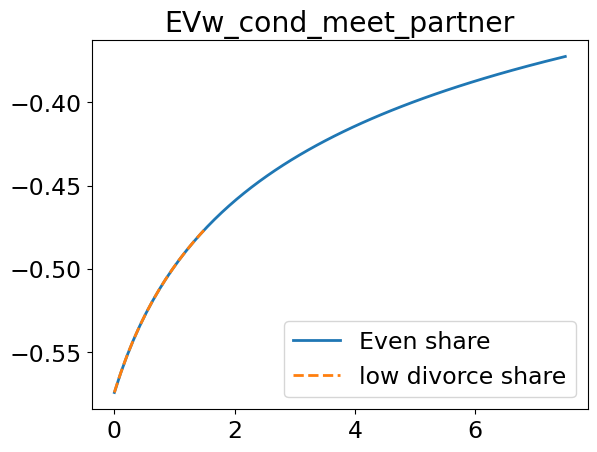

In [25]:
t = 9
var = 'Vw_single_to_single'
var = "EVw_cond_meet_partner"
grid = "grid_Aw"

i = 0
for m in models.values():
    plt.plot(getattr(m.par,grid), getattr(m.sol,var)[t], label=m.spec['latexname'], linewidth=2, linestyle=linestyles[i], )
    plt.title(var)
    i+=1
plt.legend()


### Simulation checks

In [22]:
for model in models.values():
    model.simulate()

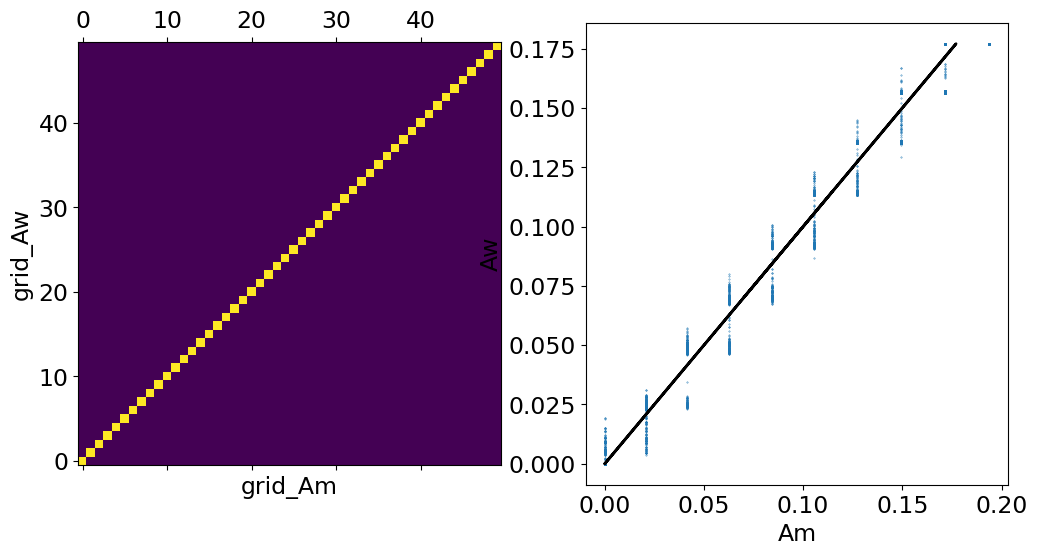

In [23]:
m = m2
# identify repartner
ones = np.ones(m.par.simN)
couple = np.column_stack((ones,m.sim.couple[:,:-1]))
single = couple == 0
meet_new = (m.sim.draw_meet < m.par.p_meet)
meet  = np.logical_and(meet_new, single)
o = np.zeros(m.par.simN, dtype=bool)
repartner = np.column_stack((o, np.diff(m.sim.couple) == 1))

Aw = m.sim.A_own[meet]
Ap = m.sim.A_partner[meet]


# make a plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.matshow(m.par.prob_partner_A_w)
ax.set_xlabel('grid_Am')
ax.set_ylabel('grid_Aw')
ax.invert_yaxis()


ax = fig.add_subplot(1,2,2)
ax.scatter(Ap, Aw, s=0.1)
ax.set_xlabel('Am')
ax.set_ylabel('Aw')
ax.plot(m.sim.A_own[meet], m.sim.A_own[meet], color='black', linewidth=2);

(array([    8,    10,    17, ..., 49975, 49986, 49999], dtype=int64),)


Text(0.5, 1.0, 'Even share')

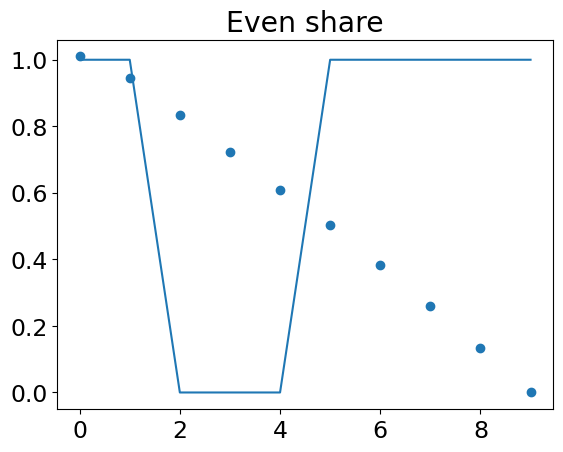

In [ ]:
m = m1
i = 8
print(np.where(np.diff(m.sim.couple).max(axis=1)))
plt.scatter(range(m.par.T),m.sim.Aw[i,:], label='Aw')
plt.plot(range(m.par.T),m.sim.couple[i,:], label='couple')
plt.title(m.spec['latexname'])